In [104]:
import numpy as np

In [105]:
def generate_linear(n=100):
    import numpy as np
    pts=np.random.uniform(0, 1, (n,2))
    inputs=[]
    labels=[]
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance=(pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n,1)

In [106]:
def generate_XOR_easy():
    import numpy as np
    inputs=[]
    labels=[]
    
    for i in range (11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        
        if 0.1*i == 0.5:
            continue
            
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
        
    return np.array(inputs),np.array(labels).reshape(21, 1)

In [107]:
class DeepNeuralNetwork():
    def __init__(self, sizes, activation="sigmoid"):
        self.sizes = sizes
        
        if activation == "sigmoid":
            self.activation = self.sigmoid
        elif activation == "relu":
            self.activation = self.relu
        elif activation == "none":
            self.activation = self.none
        
        # Save all weights
        self.params = self.initialize()
        
        # Save all intermediate values, i.e. activations
        self.cache = {}
        
        # Save the output from feed_forward
        self.output = []
        
        # Transform output into pred_y 
        self.pred_y = []
        
        # Save (ground_truth, prediction)
        self.testing = []
        
        # Save final_loss and final_acc
        self.final_loss = 0.0
        self.final_acc = 0.0
        
        # Save mean mse_loss for each epoch
        self.loss = []
    
    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))
    
    def relu(self, x, derivative=False):
        if derivative:
            return np.where(x < 0, 0, 1)
        return np.maximum(0, x)
    
    def none(self, x, derivative=False):
        if derivative:
            return 1
        return x
    
    def initialize(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_layer1=self.sizes[1]
        hidden_layer2=self.sizes[2] 
        output_layer=self.sizes[3]
        
        params = {
            "W1": np.random.randn(input_layer, hidden_layer1), 
            "W2": np.random.randn(hidden_layer1, hidden_layer2),
            "W3": np.random.randn(hidden_layer2, output_layer)
        }
        return params
    
    def initialize_momentum_optimizer(self):
        momentum_opt = {
            "W1": np.zeros(self.params["W1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "W3": np.zeros(self.params["W3"].shape)
        }
        return momentum_opt
    
    def feed_forward(self, x):
        """
        y = σ(wX)
        """
        self.cache["X"] = x
        # X:(100,2) W1:(2,4)=> H1:(100,4) 
        self.cache["H1"] = np.dot(self.cache["X"], self.params["W1"]) 
        self.cache["Z1"] = self.activation(self.cache["H1"])
        
        # Z1:(100, 4) W2:(4,4) => H2:(100, 4)
        self.cache["H2"] = np.dot(self.cache["Z1"], self.params["W2"]) 
        self.cache["Z2"] = self.activation(self.cache["H2"])
        
        # Z3:(100, 4) W3:(4, 1) => H3:(100, 1)
        self.cache["H3"] = np.dot(self.cache["Z2"], self.params["W3"])
        self.cache["Z3"] = self.activation(self.cache["H3"])
        
        return self.cache["Z3"]
    
    def back_propagate(self, y, output):
        product_dW3 = (output-y) * self.activation(self.cache["H3"], derivative=True)
        dW3 = np.dot(self.cache["Z2"].T, product_dW3)
        
        dW2 = np.dot(product_dW3, self.params["W3"].T)
        product_dW2 = dW2 * self.activation(self.cache["H2"], derivative=True)
        dW2 = np.dot(self.cache["Z1"].T, product_dW2)

        dW1 = np.dot(product_dW2, self.params["W2"].T)
        dW1 = np.dot(self.cache["X"].T,dW1)
        
        self.grads = {"W1": dW1, "W2": dW2, "W3": dW3}
        return self.grads
    
    def optimize(self, l_rate=0.1, beta=0.9):
        """
        Stochatic Gradient Descent (SGD):
        θ^(t+1) <- θ^t - η∇L(y, ŷ)

        Momentum:
        v^(t+1) <- βv^t + (1-β)∇L(y, ŷ)^t
        θ^(t+1) <- θ^t - ηv^(t+1)
        """
        if self.optimizer == "sgd":
            for key in self.params:
                self.params[key] = self.params[key] - l_rate * self.grads[key]
        elif self.optimizer == 'momentum':
            for key in self.params:
                self.momentum_opt[key] = (beta * self.momentum_opt[key] + (1. - beta) * self.grads[key])
                self.params[key] = self.params[key] - l_rate * self.momentum_opt[key]
        else:
            raise ValueError("Optimizer is currently not support, please use 'sgd' or 'momentum' instead.")
            
    def mse_loss(self, y, output):
        """
        Mean squared error loss
        :param y: prediction 
        :param output: ground truth
        :return: loss
        """
        return np.mean((y - output) ** 2)
    
    def predict(self, output):
        return np.round(output)
            
    def accuracy(self, pred_y, y):
        return (np.sum(pred_y == y) / y.shape[0]) * 100
    
    def train(self, epochs=1000, optimizer="sgd", l_rate=0.1, beta = 0.9):
        self.epochs = epochs
        
        self.optimizer = optimizer
        if self.optimizer == "momentum":
            self.momentum_opt = self.initialize_momentum_optimizer()
        
        for i in range(self.epochs):
            # Shuffle
            # permutation = np.random.permutation(x.shape[0])
            # x_shuffled = x[permutation]
            # y_shuffled = y[permutation]
            
            # Forward
            output = self.feed_forward(x)
            # Back-propagation
            grad = self.back_propagate(y, output)
            # Optimize
            self.optimize(l_rate=l_rate, beta=beta)          
            
            loss = self.mse_loss(y, output)
            self.loss.append(loss)
            
            pred_y = self.predict(output)
    
            acc = self.accuracy(pred_y, y)
            
            if (i % (self.epochs//10)) == 0:
                print(f'Epoch:{i:4} loss:{loss:.6f} acc:{acc:3.2f}%')
                
            if i+1 == self.epochs:
                self.output.append(output)
                self.pred_y.append(pred_y)
                self.testing.append((y, output))
                self.final_loss = loss
                self.final_acc = acc
                
#             if acc == 100:
#                 print(f"acc=100 epoch = {i}")

#             if acc > 99.99 or loss < 0.001:
#                 break

In [108]:
def show_result(x, y, pred_y):
    import matplotlib.pyplot as plt
    plt.subplot(1,2,1)
    plt.title('Ground truth', fontsize=18)
    for i in range (x.shape[0]): # x.shape = (100, 2)
        if y[i]==0:
            plt.plot(x[i][0],x[i][1],'ro')
        else:
            plt.plot(x[i][0],x[i][1],'bo')
            
    plt.subplot(1,2,2)
    plt.title('Predict result',fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i]==0:
            plt.plot(x[i][0],x[i][1],'ro')
        else:
            plt.plot(x[i][0],x[i][1],'bo')
            
    plt.show()

In [109]:
def plot_loss(loss):
    import matplotlib.pyplot as plt
    plt.plot(loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("MSE Loss curve")
    plt.show()

In [110]:
np.random.seed(1)
x, y = generate_linear(n=100)

In [111]:
# fig. a (training)
# Sigmoid + SGD
dnn = DeepNeuralNetwork(sizes=[2, 10, 10, 1], activation="sigmoid")
dnn.train(epochs = 51, l_rate=0.1)

Epoch:   0 loss:0.358400 acc:58.00%
Epoch:   5 loss:0.263512 acc:58.00%
Epoch:  10 loss:0.199258 acc:70.00%
Epoch:  15 loss:0.162447 acc:67.00%
Epoch:  20 loss:0.092607 acc:90.00%
Epoch:  25 loss:0.058728 acc:94.00%
Epoch:  30 loss:0.042800 acc:97.00%
Epoch:  35 loss:0.034942 acc:98.00%
Epoch:  40 loss:0.030036 acc:100.00%
Epoch:  45 loss:0.027053 acc:100.00%
Epoch:  50 loss:0.024744 acc:100.00%


In [112]:
# fig. b (testing)
zipped = zip(dnn.testing[0][0], dnn.testing[0][1])

for index, element in enumerate(zipped):
    print(f'Iter{index:2} |    Ground truth: {element[0][0]:.1f} |    prediction: {element[1][0]:.5f} |')
    
print(f'loss={dnn.final_loss:.5f} accuracy={dnn.final_acc:.2f}%')

Iter 0 |    Ground truth: 1.0 |    prediction: 0.96086 |
Iter 1 |    Ground truth: 1.0 |    prediction: 0.97207 |
Iter 2 |    Ground truth: 0.0 |    prediction: 0.35178 |
Iter 3 |    Ground truth: 1.0 |    prediction: 0.90515 |
Iter 4 |    Ground truth: 1.0 |    prediction: 0.87091 |
Iter 5 |    Ground truth: 1.0 |    prediction: 0.95065 |
Iter 6 |    Ground truth: 1.0 |    prediction: 0.98989 |
Iter 7 |    Ground truth: 1.0 |    prediction: 0.99050 |
Iter 8 |    Ground truth: 1.0 |    prediction: 0.86797 |
Iter 9 |    Ground truth: 1.0 |    prediction: 0.73073 |
Iter10 |    Ground truth: 1.0 |    prediction: 0.84691 |
Iter11 |    Ground truth: 1.0 |    prediction: 0.97625 |
Iter12 |    Ground truth: 1.0 |    prediction: 0.57572 |
Iter13 |    Ground truth: 0.0 |    prediction: 0.38105 |
Iter14 |    Ground truth: 1.0 |    prediction: 0.99057 |
Iter15 |    Ground truth: 1.0 |    prediction: 0.97407 |
Iter16 |    Ground truth: 0.0 |    prediction: 0.03209 |
Iter17 |    Ground truth: 0.0 |

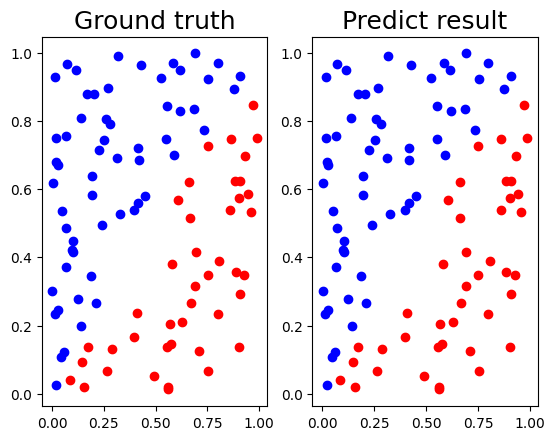

In [113]:
# Plot comparison figure between Ground truths and Predicted results
pred_y = np.array(dnn.pred_y)
num_elements = pred_y.shape[1]
pred_y = pred_y.reshape(num_elements, 1)

show_result(x, y, pred_y)

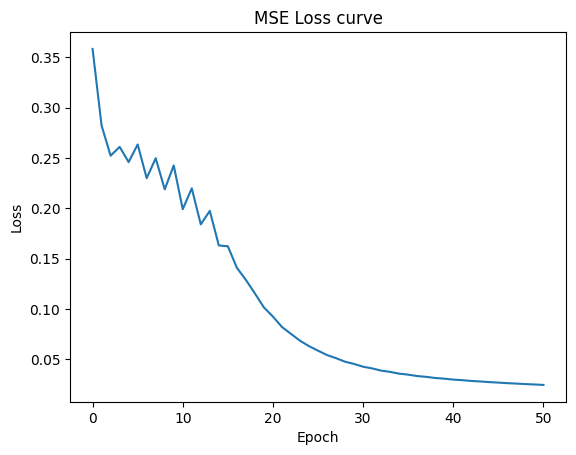

In [114]:
# Plot mse loss curve
plot_loss(dnn.loss)

In [115]:
# relu + SGD
np.random.seed(4)
dnn = DeepNeuralNetwork(sizes=[2, 4, 4, 1], activation="relu")
dnn.train(epochs = 10001, l_rate=0.01)

Epoch:   0 loss:0.417119 acc:42.00%
Epoch:1000 loss:0.105709 acc:88.00%
Epoch:2000 loss:0.107252 acc:88.00%
Epoch:3000 loss:0.107806 acc:89.00%
Epoch:4000 loss:0.108537 acc:87.00%
Epoch:5000 loss:0.108462 acc:87.00%
Epoch:6000 loss:0.108420 acc:87.00%
Epoch:7000 loss:0.108394 acc:87.00%
Epoch:8000 loss:0.108376 acc:87.00%
Epoch:9000 loss:0.108364 acc:88.00%
Epoch:10000 loss:0.108354 acc:88.00%


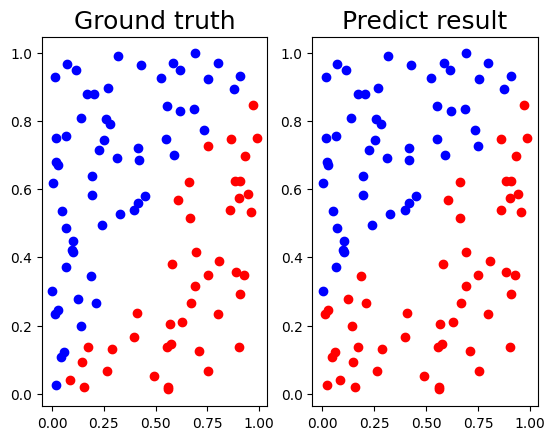

In [116]:
pred_y = np.array(dnn.pred_y)
num_elements = pred_y.shape[1]
pred_y = pred_y.reshape(num_elements, 1)

show_result(x, y, pred_y)

In [117]:
# Sigmoid + Momentum
np.random.seed(4)
dnn = DeepNeuralNetwork(sizes=[2, 4, 4, 1], activation="sigmoid")
dnn.train(epochs = 101, optimizer="momentum", l_rate=0.1, beta=0.9)

Epoch:   0 loss:0.303472 acc:58.00%
Epoch:  10 loss:0.233734 acc:74.00%
Epoch:  20 loss:0.210273 acc:71.00%
Epoch:  30 loss:0.164940 acc:83.00%
Epoch:  40 loss:0.096741 acc:95.00%
Epoch:  50 loss:0.051386 acc:96.00%
Epoch:  60 loss:0.029887 acc:98.00%
Epoch:  70 loss:0.020754 acc:99.00%
Epoch:  80 loss:0.016687 acc:100.00%
Epoch:  90 loss:0.014425 acc:100.00%
Epoch: 100 loss:0.013088 acc:100.00%


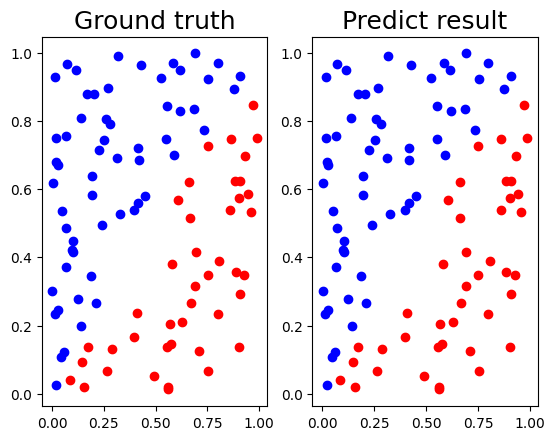

In [118]:
pred_y = np.array(dnn.pred_y)
num_elements = pred_y.shape[1]
pred_y = pred_y.reshape(num_elements, 1)

show_result(x, y, pred_y)

In [119]:
x, y = generate_XOR_easy()

In [120]:
# Sigmoid + SGD
np.random.seed(4)
dnn = DeepNeuralNetwork(sizes=[2, 4, 4, 1], activation="sigmoid")
dnn.train(epochs = 1001, l_rate=0.1)

Epoch:   0 loss:0.374859 acc:47.62%
Epoch: 100 loss:0.249373 acc:52.38%
Epoch: 200 loss:0.249138 acc:52.38%
Epoch: 300 loss:0.248945 acc:52.38%
Epoch: 400 loss:0.248721 acc:52.38%
Epoch: 500 loss:0.248191 acc:52.38%
Epoch: 600 loss:0.246140 acc:57.14%
Epoch: 700 loss:0.235422 acc:71.43%
Epoch: 800 loss:0.177223 acc:90.48%
Epoch: 900 loss:0.082453 acc:95.24%
Epoch:1000 loss:0.036723 acc:100.00%


In [121]:
# fig. b (testing)
zipped = zip(dnn.testing[0][0], dnn.testing[0][1])

for index, element in enumerate(zipped):
    print(f'Iter{index:2} |    Ground truth: {element[0][0]:.1f} |    prediction: {element[1][0]:.5f} |')
    
print(f'loss={dnn.final_loss:.5f} accuracy={dnn.final_acc:.2f}%')

Iter 0 |    Ground truth: 0.0 |    prediction: 0.22034 |
Iter 1 |    Ground truth: 1.0 |    prediction: 0.87306 |
Iter 2 |    Ground truth: 0.0 |    prediction: 0.21016 |
Iter 3 |    Ground truth: 1.0 |    prediction: 0.87120 |
Iter 4 |    Ground truth: 0.0 |    prediction: 0.20110 |
Iter 5 |    Ground truth: 1.0 |    prediction: 0.86649 |
Iter 6 |    Ground truth: 0.0 |    prediction: 0.19310 |
Iter 7 |    Ground truth: 1.0 |    prediction: 0.84446 |
Iter 8 |    Ground truth: 0.0 |    prediction: 0.18610 |
Iter 9 |    Ground truth: 1.0 |    prediction: 0.66197 |
Iter10 |    Ground truth: 0.0 |    prediction: 0.18003 |
Iter11 |    Ground truth: 0.0 |    prediction: 0.17480 |
Iter12 |    Ground truth: 1.0 |    prediction: 0.63064 |
Iter13 |    Ground truth: 0.0 |    prediction: 0.17035 |
Iter14 |    Ground truth: 1.0 |    prediction: 0.84307 |
Iter15 |    Ground truth: 0.0 |    prediction: 0.16660 |
Iter16 |    Ground truth: 1.0 |    prediction: 0.87373 |
Iter17 |    Ground truth: 0.0 |

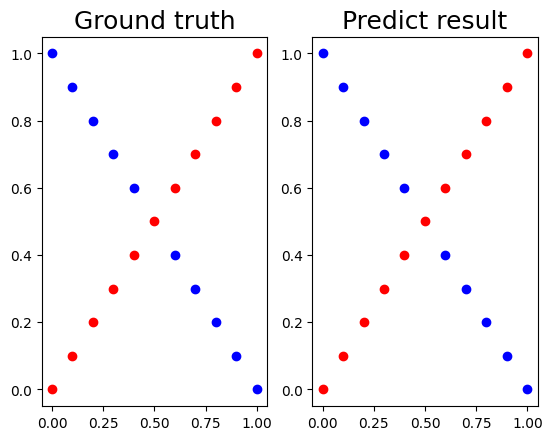

In [122]:
pred_y = np.array(dnn.pred_y)
num_elements = pred_y.shape[1]
pred_y = pred_y.reshape(num_elements, 1)

show_result(x, y, pred_y)

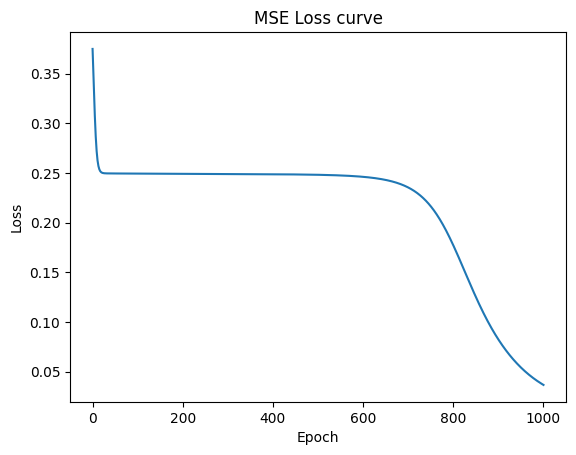

In [123]:
plot_loss(dnn.loss)